In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime


In [2]:
verbrauch = pd.read_csv('Realisierter_Stromverbrauch_201501010000_202412020000_Viertelstunde.csv',sep=';')
erzeugung = pd.read_csv('Realisierte_Erzeugung_201501010000_202412020000_Viertelstunde.csv',sep=';')
preis = pd.read_csv('Gro_handelspreise_201501010000_202412020000_Stunde.csv',sep=';')


In [3]:
# First, let's process the timestamps in the dataframes
for df in [verbrauch, erzeugung, preis]:
    df['Datum von'] = pd.to_datetime(df['Datum von'], format='%d.%m.%Y %H:%M')
    df['Datum bis'] = pd.to_datetime(df['Datum bis'], format='%d.%m.%Y %H:%M')

# Resample preis to 15-minute intervals to match other dataframes
preis_resampled = preis.drop_duplicates(subset='Datum von').set_index('Datum von').resample('15T').ffill().reset_index()

# Merge the dataframes on 'Datum von'
combined_df = verbrauch.merge(erzeugung, on=['Datum von', 'Datum bis'], how='outer')
combined_df = combined_df.merge(preis_resampled[['Datum von', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']], 
                              on='Datum von', 
                              how='outer')

# Clean up numeric columns by removing thousand separators and converting to float
numeric_columns = combined_df.select_dtypes(include=['object']).columns
for col in numeric_columns:
    if col not in ['Datum von', 'Datum bis']:
        # Replace '-' with NaN and convert to float
        combined_df[col] = combined_df[col].str.replace('.', '').str.replace(',', '.').replace('-', np.nan).astype(float)
        combined_df[col] = combined_df[col].ffill()

C:\Users\TimPr\AppData\Local\Temp\ipykernel_52812\3171798497.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  preis_resampled = preis.drop_duplicates(subset='Datum von').set_index('Datum von').resample('15T').ffill().reset_index()


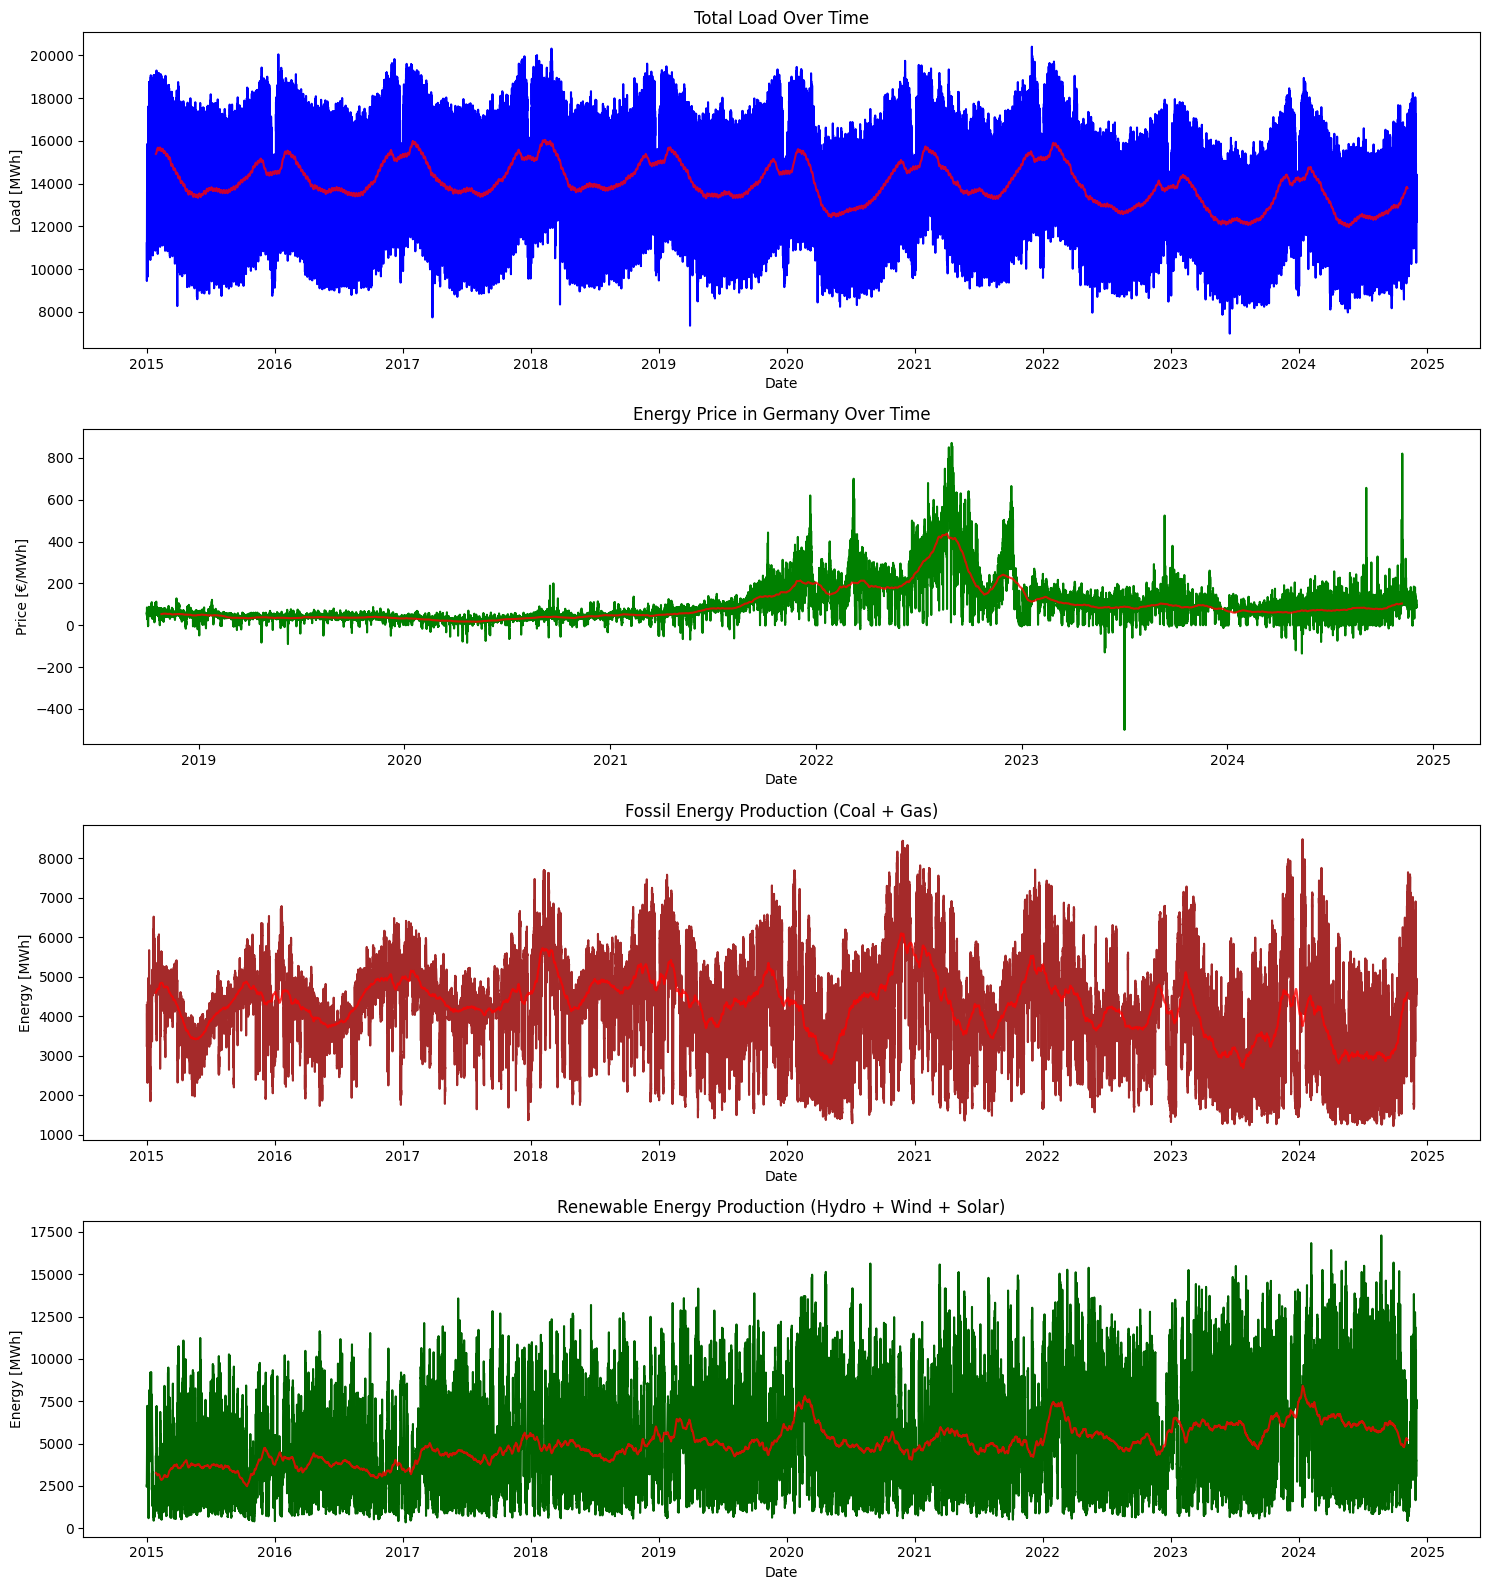

In [4]:
# Define the rolling window size
rolling_window = 5000  # Adjust based on the level of smoothing required

# Plot setup
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 16))

# Plot 1: Load over time (blue)
ax1.plot(combined_df['Datum von'], combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'], color='blue')
ax1.set_title('Total Load Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load [MWh]')
# Rolling mean for smoothing
trend1 = combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'].rolling(window=rolling_window, center=True).mean()
ax1.plot(combined_df['Datum von'], trend1, "r-", alpha=0.8)

# Plot 2: Energy price in Germany (green)
valid_prices = combined_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].dropna()
valid_dates = combined_df['Datum von'][valid_prices.index]
ax2.plot(combined_df['Datum von'], combined_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'], color='green')
ax2.set_title('Energy Price in Germany Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price [€/MWh]')
# Rolling mean for smoothing
trend2 = combined_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].rolling(window=rolling_window, center=True).mean()
ax2.plot(combined_df['Datum von'], trend2, "r-", alpha=0.8)

# Plot 3: Fossil Energy (brown)
fossil = combined_df['Braunkohle [MWh] Originalauflösungen'] + combined_df['Erdgas [MWh] Originalauflösungen']
ax3.plot(combined_df['Datum von'], fossil, color='brown')
ax3.set_title('Fossil Energy Production (Coal + Gas)')
ax3.set_xlabel('Date')
ax3.set_ylabel('Energy [MWh]')
# Rolling mean for smoothing
trend3 = fossil.rolling(window=rolling_window, center=True).mean()
ax3.plot(combined_df['Datum von'], trend3, "r-", alpha=0.8)

# Plot 4: Renewable Energy (green)
renewable = (combined_df['Wasserkraft [MWh] Originalauflösungen'] + 
             combined_df['Wind Offshore [MWh] Originalauflösungen'] + 
             combined_df['Wind Onshore [MWh] Originalauflösungen'] + 
             combined_df['Photovoltaik [MWh] Originalauflösungen'])
ax4.plot(combined_df['Datum von'], renewable, color='darkgreen')
ax4.set_title('Renewable Energy Production (Hydro + Wind + Solar)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Energy [MWh]')
# Rolling mean for smoothing
trend4 = renewable.rolling(window=rolling_window, center=True).mean()
ax4.plot(combined_df['Datum von'], trend4, "r-", alpha=0.8)

plt.tight_layout()
plt.show()


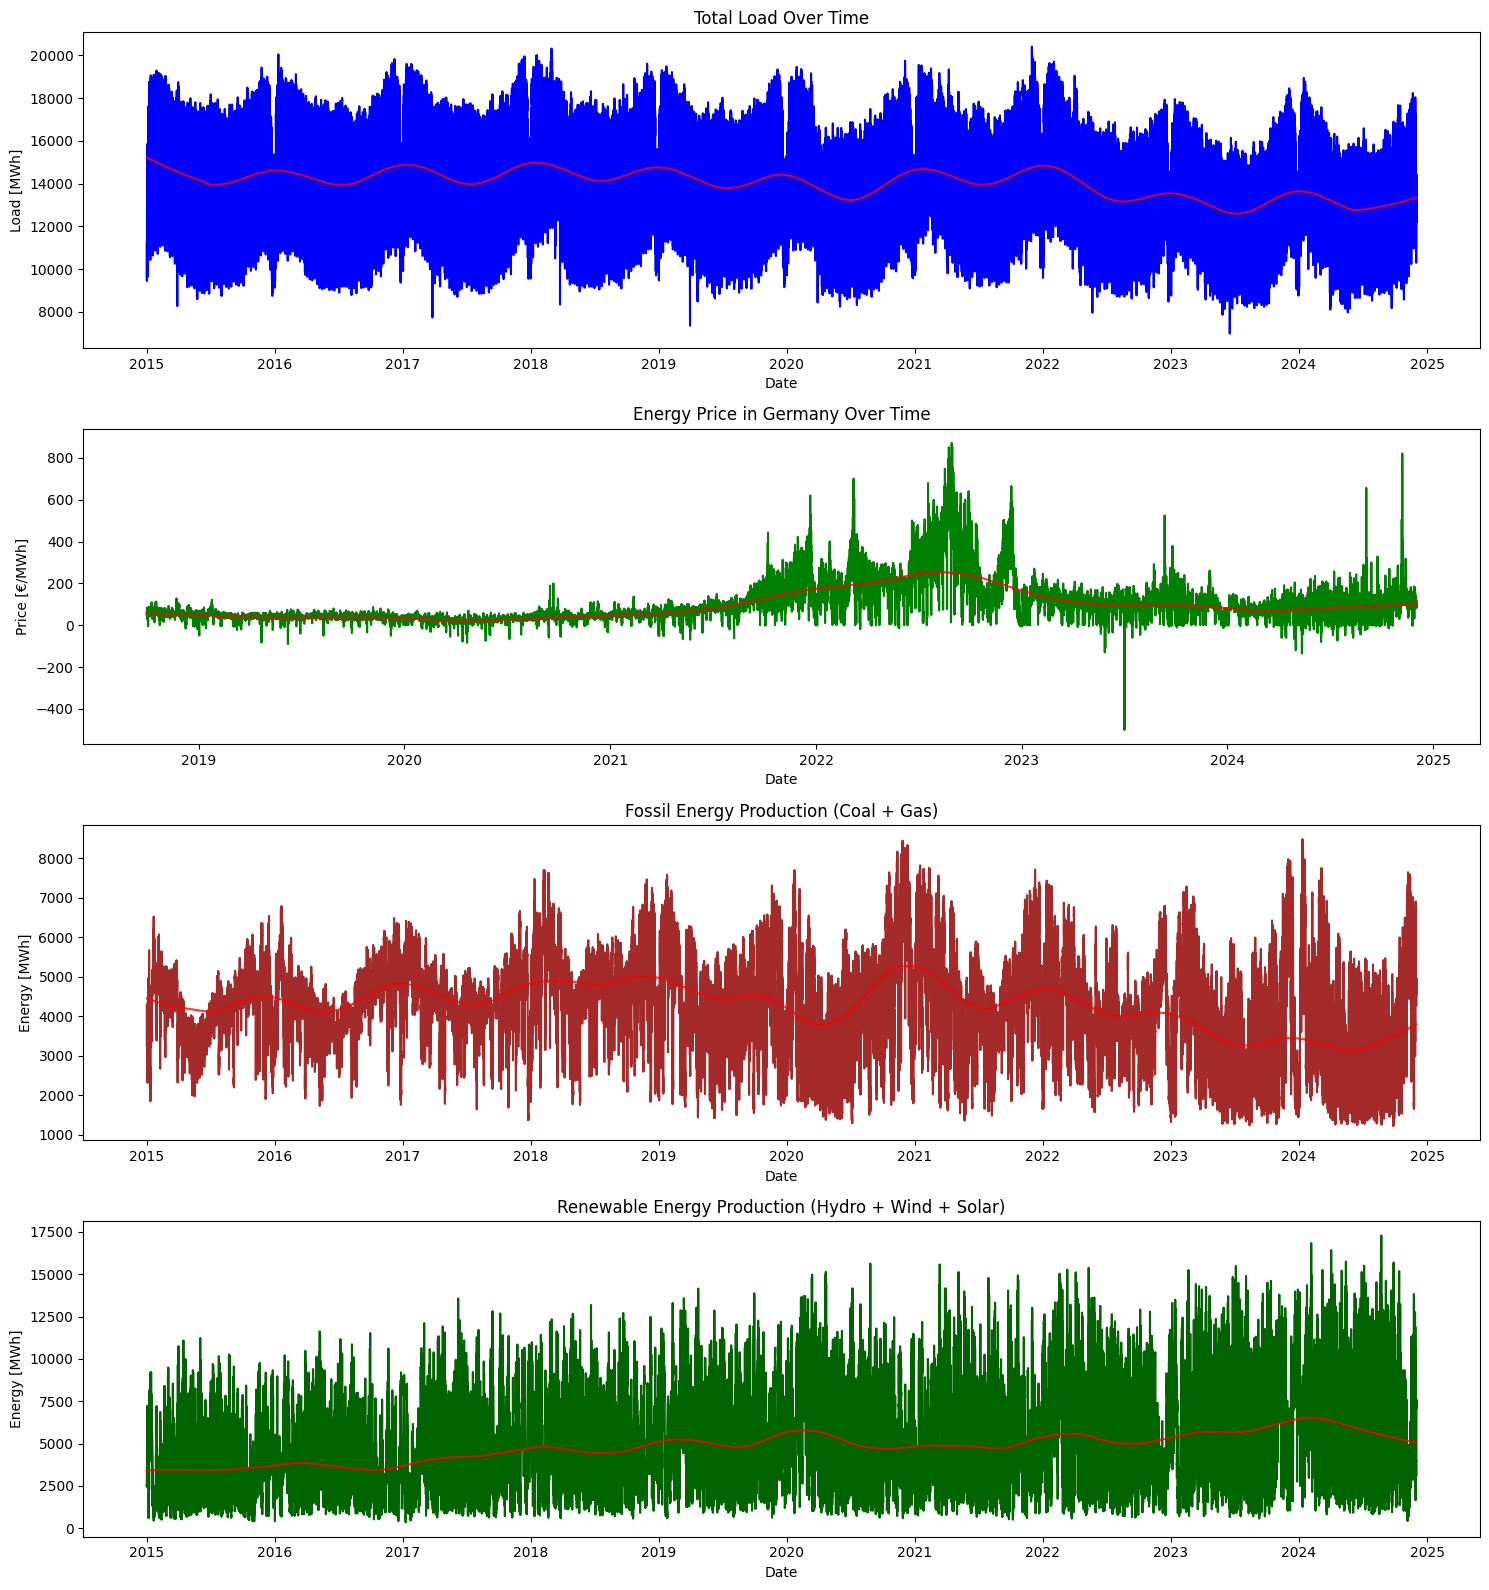

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Downsample factor (e.g., 10 for taking every 10th point)
downsample_factor = 10

# Downsampled indices
downsampled_indices = np.arange(0, len(combined_df), downsample_factor)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 16))

# Plot 1: Load over time (blue)
ax1.plot(combined_df['Datum von'], combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'], color='blue')
ax1.set_title('Total Load Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load [MWh]')
trend1 = lowess(
    combined_df['Gesamt (Netzlast) [MWh] Originalauflösungen'][downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax1.plot(combined_df['Datum von'][downsampled_indices], trend1[:, 1], "r-", alpha=0.8)

# Plot 2: Energy price in Germany (green)
valid_prices = combined_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].dropna()
valid_dates = combined_df['Datum von'][valid_prices.index]
downsampled_indices_prices = np.arange(0, len(valid_prices), downsample_factor)
ax2.plot(combined_df['Datum von'], combined_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'], color='green')
ax2.set_title('Energy Price in Germany Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price [€/MWh]')
trend2 = lowess(
    valid_prices.iloc[downsampled_indices_prices], 
    downsampled_indices_prices, 
    frac=0.1
)
ax2.plot(valid_dates.iloc[downsampled_indices_prices], trend2[:, 1], "r-", alpha=0.8)

# Plot 3: Fossil Energy (brown)
fossil = combined_df['Braunkohle [MWh] Originalauflösungen'] + combined_df['Erdgas [MWh] Originalauflösungen']
ax3.plot(combined_df['Datum von'], fossil, color='brown')
ax3.set_title('Fossil Energy Production (Coal + Gas)')
ax3.set_xlabel('Date')
ax3.set_ylabel('Energy [MWh]')
trend3 = lowess(
    fossil[downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax3.plot(combined_df['Datum von'][downsampled_indices], trend3[:, 1], "r-", alpha=0.8)

# Plot 4: Renewable Energy (green)
renewable = (combined_df['Wasserkraft [MWh] Originalauflösungen'] + 
             combined_df['Wind Offshore [MWh] Originalauflösungen'] + 
             combined_df['Wind Onshore [MWh] Originalauflösungen'] + 
             combined_df['Photovoltaik [MWh] Originalauflösungen'])
ax4.plot(combined_df['Datum von'], renewable, color='darkgreen')
ax4.set_title('Renewable Energy Production (Hydro + Wind + Solar)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Energy [MWh]')
trend4 = lowess(
    renewable[downsampled_indices], 
    downsampled_indices, 
    frac=0.1
)
ax4.plot(combined_df['Datum von'][downsampled_indices], trend4[:, 1], "r-", alpha=0.8)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


When do we need energy and how much?

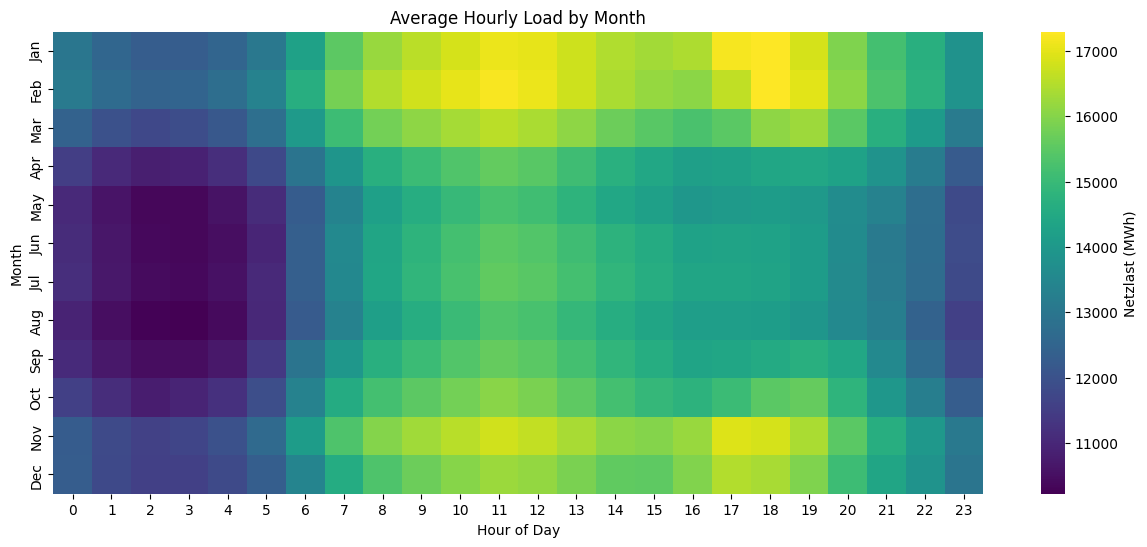

In [9]:
# Extract hour from datetime and create pivot table for monthly-hourly averages
combined_df['Hour'] = combined_df['Datum von'].dt.hour
combined_df['Month'] = combined_df['Datum von'].dt.month

hourly_monthly_avg = combined_df.pivot_table(
    values='Gesamt (Netzlast) [MWh] Originalauflösungen', 
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

# Create heatmap with switched axes
plt.figure(figsize=(15, 6))
sns.heatmap(hourly_monthly_avg.T, 
            cmap='viridis',
            annot=False,
            cbar_kws={'label': 'Netzlast (MWh)'},
            yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.title('Average Hourly Load by Month')
plt.ylabel('Month')
plt.xlabel('Hour of Day')
plt.show()


How much do we produce and when?

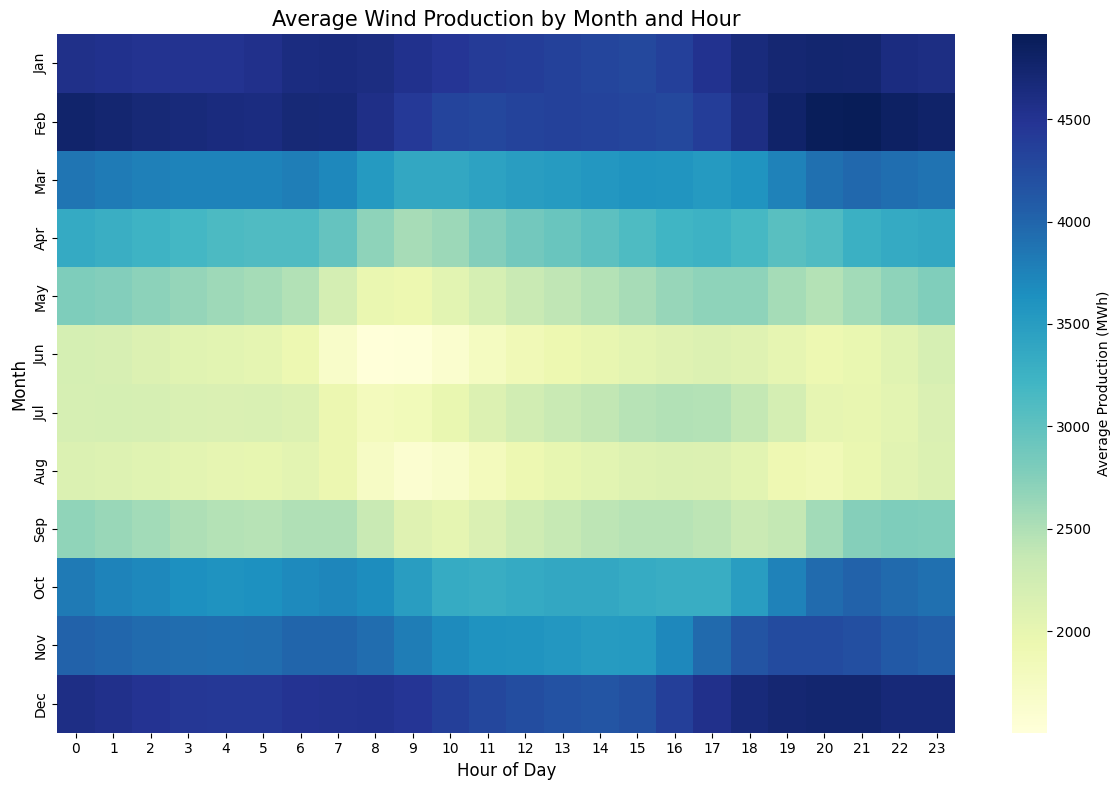

In [13]:
# Combine Wind Offshore and Wind Onshore
erzeugung['Total Wind [MWh]'] = pd.to_numeric(erzeugung['Wind Offshore [MWh] Originalauflösungen'].str.replace('.','').str.replace(',','.')) + \
                                pd.to_numeric(erzeugung['Wind Onshore [MWh] Originalauflösungen'].str.replace('.','').str.replace(',','.'))

# Extract hour and month from datetime
erzeugung['Hour'] = erzeugung['Datum von'].dt.hour
erzeugung['Month'] = erzeugung['Datum von'].dt.month

# Create pivot table with hours as columns and months as rows, using mean of total wind production
pivot_wind = pd.pivot_table(
    data=erzeugung, 
    values='Total Wind [MWh]',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_wind,
    cmap='YlGnBu', 
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Wind Production by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

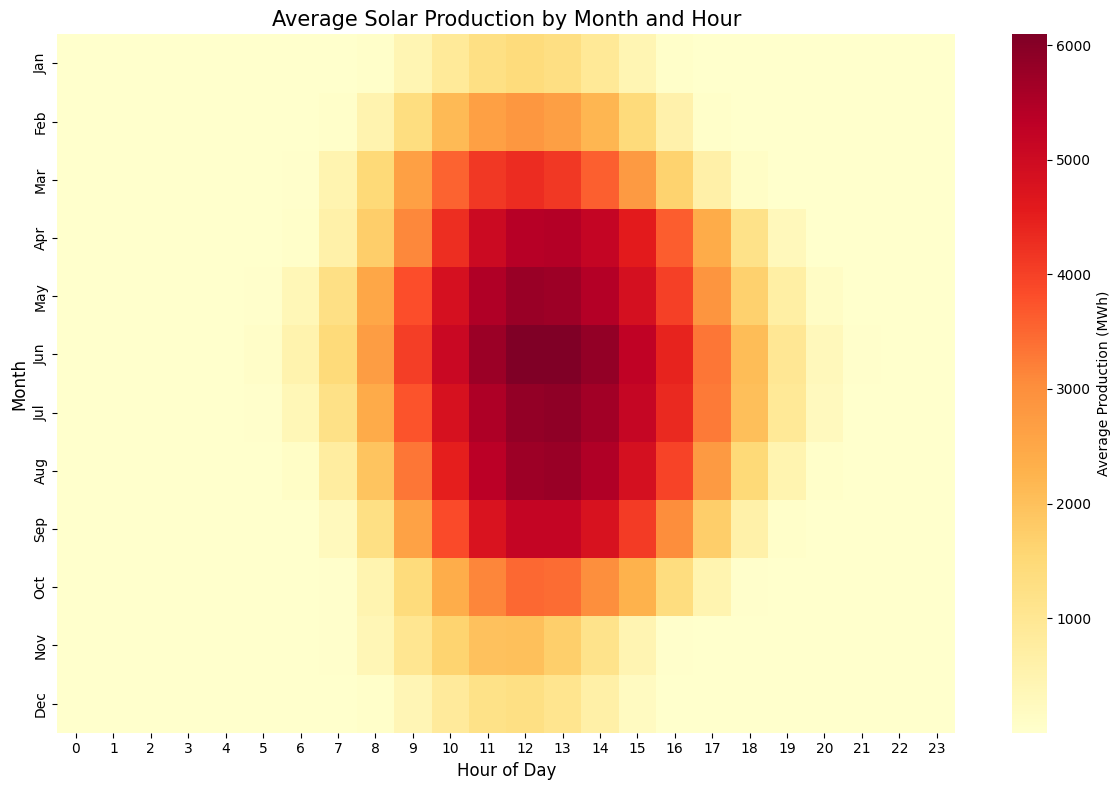

In [21]:
# Create pivot table with hours as columns and months as rows, using mean of Photovoltaik production
pivot_pv = pd.pivot_table(
    data=combined_df,
    values='Photovoltaik [MWh] Originalauflösungen',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_pv,
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Solar Production by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

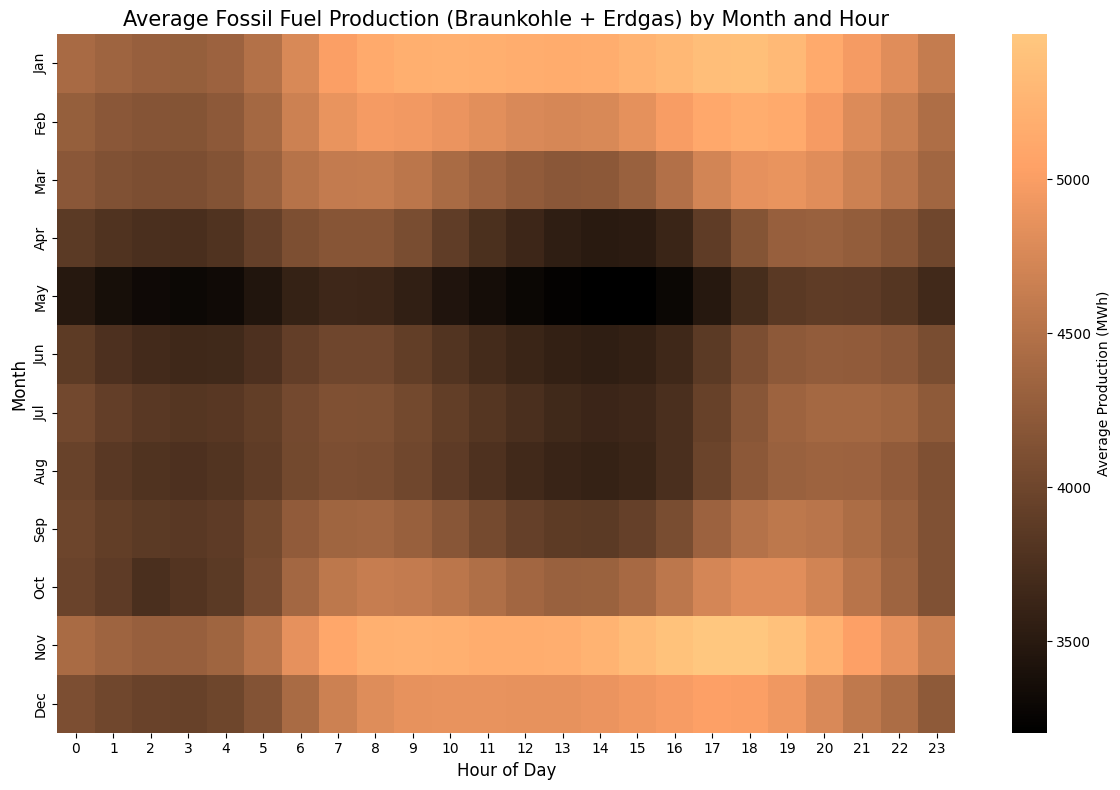

In [25]:
# Combine Braunkohle and Erdgas
combined_df['Total Fossil [MWh]'] = combined_df['Braunkohle [MWh] Originalauflösungen'] + combined_df['Erdgas [MWh] Originalauflösungen']

# Create pivot table with hours as columns and months as rows, using mean of total fossil production
pivot_fossil = pd.pivot_table(
    data=combined_df, 
    values='Total Fossil [MWh]',
    index='Month',
    columns='Hour',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_fossil,
    cmap='copper',  # Using Reds colormap for fossil fuels
    cbar_kws={'label': 'Average Production (MWh)'},
    xticklabels=range(24),
    yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Average Fossil Fuel Production (Braunkohle + Erdgas) by Month and Hour', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

What does it cost?

In [26]:
# Calculate average price for each month and hour
monthly_hourly_profile = df.assign(
    month=df['date'].dt.month_name(),
    hour=df['date'].dt.hour
).groupby(['month', 'hour'])['Deutschland/Luxemburg [€/MWh] Originalauflösungen'].mean().unstack()

# Reorder months
monthly_hourly_profile = monthly_hourly_profile.reindex(index=months_order)

# Create heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(monthly_hourly_profile, cmap='summer',
            xticklabels=range(24),
            yticklabels=months_order,
            cbar_kws={'label': 'Price [€/MWh]'})

plt.title('Average Electricity Prices by Month and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.tight_layout()


KeyError: 'date'